**To convert Persian sentences to ParsBERT input format, the solution provided in this link has been used.**

https://sci2lab.github.io/ml_tutorial/bert_farsi_sentiment/

In [ ]:
!pip install transformers
!pip install PersianStemmer
!pip install https://github.com/htaghizadeh/PersianStemmer-Python/archive/master.zip --upgrade
!pip install hazm
!pip install demoji

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0, '/content/drive/My Drive/modules') #Adds preprocessing module to current session.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import InputExample, glue_convert_examples_to_features, TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification, BertTokenizer
import numpy as np
import tensorflow as tf
import demoji
import random
import matplotlib.pyplot as plt
import preprocess
np.random.seed(42)
tf.random.set_seed(42)
demoji.download_codes()

... OK (Got response in 0.17 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [ ]:
def convert_data_into_input_example(data):
    input_examples = []
    for i in range(len(data)):
        example = InputExample(
            guid=None,
            text_a=data.iloc[i]['sentence'],
            text_b=None,
            label=data.iloc[i]['label']
        )
        input_examples.append(example)
    return input_examples

In [ ]:
def solution(bdset):
    """ Create a list of input tensors required to be in the first argument of the
        model call function for training. e.g. `model([input_ids, attention_mask, token_type_ids])`.
    """
    input_ids, attention_mask, token_type_ids, label = [], [], [], []
    for in_ex in bdset:
        input_ids.append(in_ex.input_ids)
        attention_mask.append(in_ex.attention_mask)
        token_type_ids.append(in_ex.token_type_ids)
        label.append(in_ex.label)

    input_ids = np.vstack(input_ids)
    attention_mask = np.vstack(attention_mask)
    token_type_ids = np.vstack(token_type_ids)
    label = np.vstack(label)
    return [input_ids, attention_mask, token_type_ids], label

In [ ]:
def example_to_features(input_ids, attention_masks, token_type_ids, y):
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids}, y

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
train_df =preprocess.remove_emoji(pd.read_csv('/content/drive/MyDrive/data/silver_dataset.csv'))
test_df =preprocess.remove_emoji(pd.read_csv('/content/drive/MyDrive/data/gold_dataset.csv'))

train_df = train_df.astype({'label': 'str'})
test_df = test_df.astype({'label': 'str'})

In [ ]:
train_input_examples = convert_data_into_input_example(train_df)
test_input_examples = convert_data_into_input_example(test_df)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [ ]:
label_list = ['0', '1']

MAX_SEQ_LENGTH = 128

bert_train_dataset = glue_convert_examples_to_features(examples=train_input_examples, tokenizer=tokenizer,
                                                          max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)

bert_test_dataset = glue_convert_examples_to_features(examples=test_input_examples, tokenizer=tokenizer,
                                                        max_length=MAX_SEQ_LENGTH, task='mrpc', label_list=label_list)


/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:175: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [ ]:
x_train, y_train = solution(bert_train_dataset)
x_val, y_val = solution(bert_test_dataset)

train_ds = tf.data.Dataset.from_tensor_slices((x_train[0], x_train[1], x_train[2], y_train)).map(example_to_features).shuffle(100).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_val[0], x_val[1], x_val[2], y_val)).map(example_to_features).batch(64)

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('HooshvareLab/bert-base-parsbert-uncased') #ParsBert

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer = optimizer, loss = loss, metrics= metric)
model.summary()
history = model.fit(train_ds, validation_data = test_ds, epochs=3)

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  162841344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 162,842,882
Trainable params: 162,842,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.auto

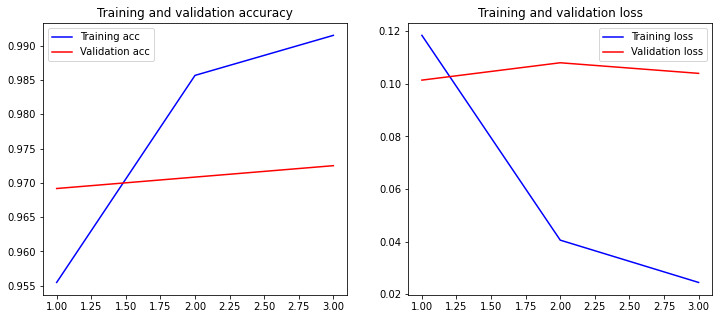

In [ ]:
plot_history(history)

In [ ]:
y_predict = model.predict(test_ds)
predictions_classes = (np.argmax(y_predict[0], axis = 1)).tolist()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
labels_list = [int(test_df['label'].iloc[index]) for index in range(len(test_df)) ]
f1 = round((f1_score(labels_list, predictions_classes)*100),2)
print('f1: ',f1)
acc = round((accuracy_score(labels_list,predictions_classes)*100),2)
print('accuracy: ', acc)
pre = round((precision_score(labels_list,predictions_classes)*100),2)
print('precision: ', pre)
rec = round((recall_score(labels_list,predictions_classes)*100),2)
rec = round(rec, 2)
print('recall: ', rec)

f1:  97.27
accuracy:  97.25
precision:  96.63
recall:  97.92
